In [28]:
import pandas as pd
import numpy as np
import geopandas as gpd
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import os
import warnings
warnings.simplefilter(action="ignore", category=pd.errors.SettingWithCopyWarning)


In [11]:
# load data
cd = os.path.abspath(os.path.join(os.getcwd(), "..", "data"))
shp = gpd.read_file(cd + "/icrisat_boundary_match.shp")[['NAME_1', 'Name_12', 'Dist_Name', 'Shape_Area', 'geometry']]
df_raw = pd.read_csv( cd+ "/yield_csif_2017.csv").iloc[:, 1:]
df = df_raw[(df_raw["year"].between(2000, 2022)) & df_raw["yield"].notna() & np.isfinite(df_raw["yield"])]
yield_mean = df["yield"].mean(skipna=True)

/var/folders/k4/2gcvspsj7d7c9hbxlvzv_zrh0000gn/T/ipykernel_31904/4013311361.py:4: DtypeWarning: Columns (9,17) have mixed types. Specify dtype option on import or set low_memory=False.
  df_raw = pd.read_csv( cd+ "/yield_csif_2017.csv").iloc[:, 1:]


In [13]:
def run_regrhttp://localhost:59328/var/folders/k4/2gcvspsj7d7c9hbxlvzv_zrh0000gn/T/ipykernel_31904/4013311361.py#line=3ession(group):
    """Runs a linear regression on log(yield + yield_mean) ~ year"""
    if len(group) < 10: 
        return pd.Series({"r2": np.nan, "year_slope": np.nan, "year_pval": np.nan})

    if group["sm"].isna().all() or group["tmax"].isna().all():  
        return pd.Series({"r2": np.nan, "year_slope": np.nan, "year_pval": np.nan})

    X = group["year"]
    y = np.log(group.loc[X.index, "yield"] + yield_mean)

    model = sm.OLS(y, sm.add_constant(X)).fit()

    return pd.Series({
        "r2": model.rsquared,
        "year_slope": model.params["year"],
        "year_pval": model.pvalues["year"]
    })

In [16]:
regs = df.groupby(["cropname", "NAME_1", "Name_12"]).apply(run_regression).reset_index()
regs = regs[(regs["r2"] < 1) & (~regs["cropname"].isna())]

# Merge with spatial data (shp equivalent)
regs_plot = shp.merge(regs, on=["NAME_1", "Name_12"])

/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


In [20]:
def plot_facet_maps(data, fill_var, title, cmap, color_var=None, color_threshold=None, vmin=None, vmax=None):
    unique_crops = data["cropname"].unique()
    num_crops = len(unique_crops)

    cols = min(num_crops, 3)  # Limit to 3 columns
    rows = (num_crops // cols) + (num_crops % cols > 0)

    fig, axes = plt.subplots(rows, cols, figsize=(6 * cols, 5 * rows))
    axes = axes.flatten() if num_crops > 1 else [axes]

    for i, crop in enumerate(unique_crops):
        ax = axes[i]
        crop_data = data[data["cropname"] == crop]

        # Plot the data
        crop_data.plot(column=fill_var, cmap=cmap, vmin=vmin, vmax=vmax, linewidth=0.5, edgecolor="none", ax=ax, legend=True)

        # Apply conditional color outline if needed
        if color_var:
            significant = crop_data[crop_data[color_var] < color_threshold]
            significant.plot(ax=ax, facecolor="none", edgecolor="black", linewidth=1.5)

        ax.set_title(f"{title} - {crop}", fontsize=14)
        ax.axis("off")

    # Remove empty subplots
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

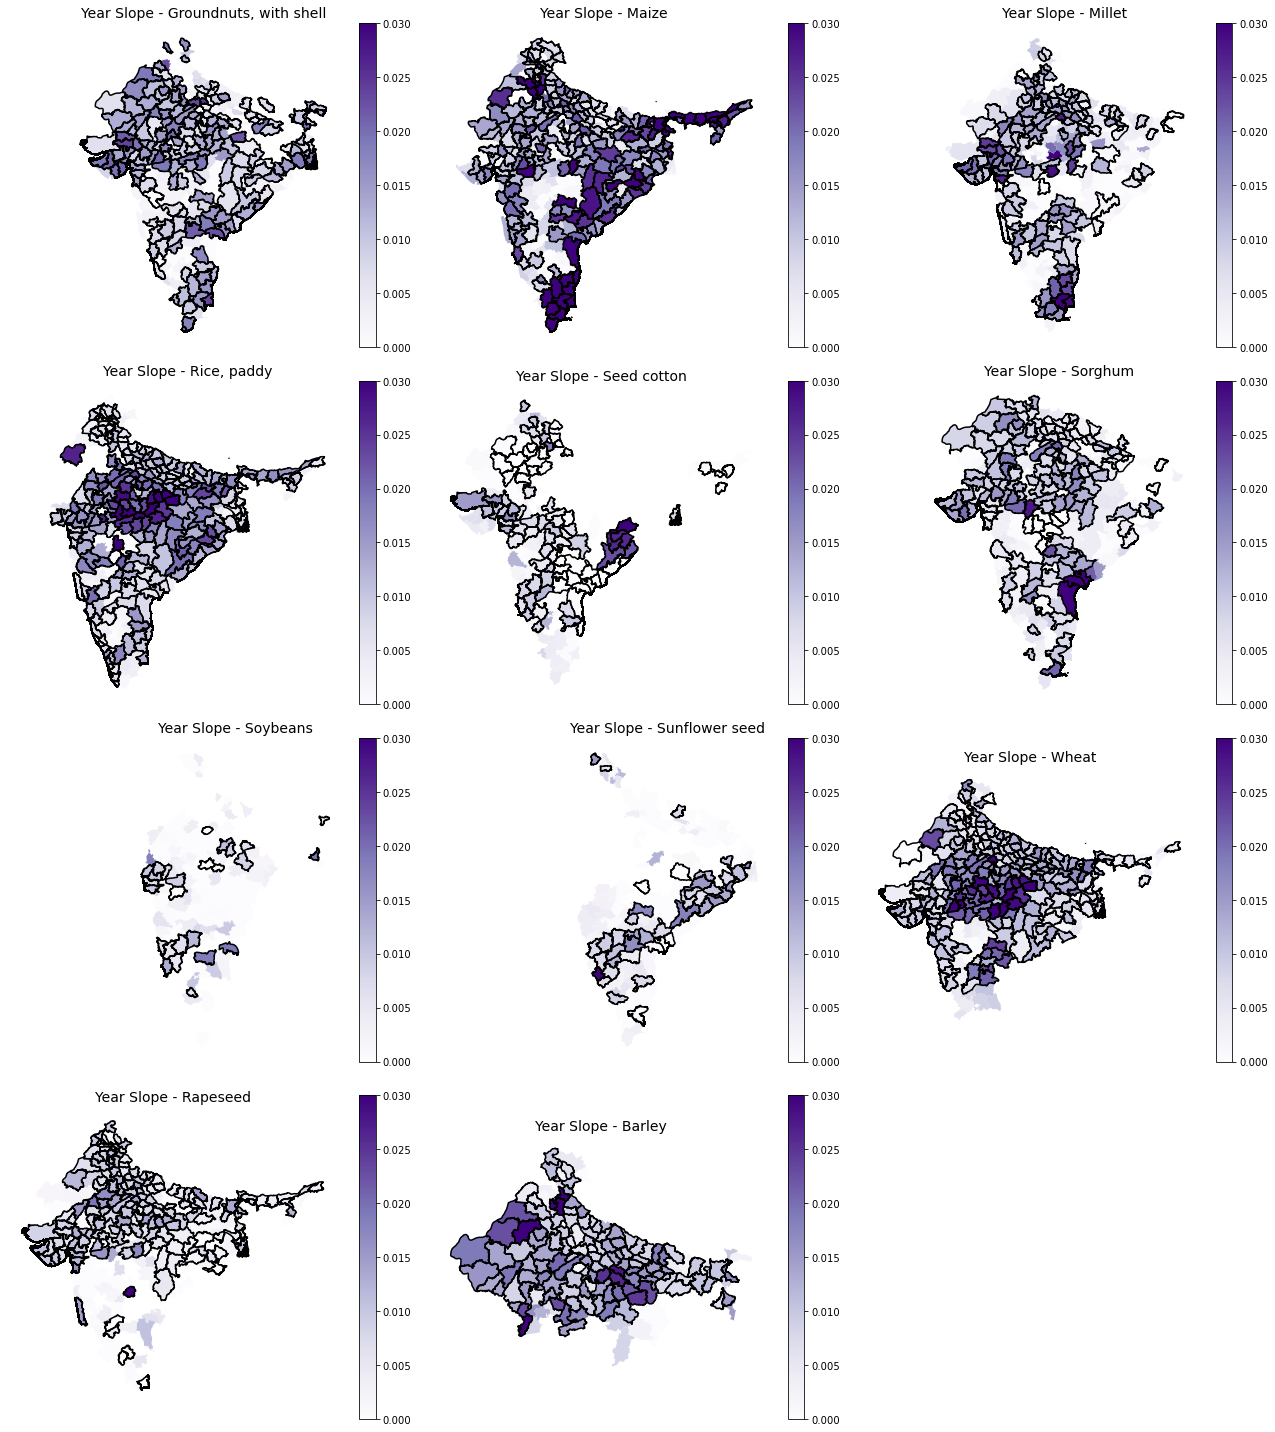

In [21]:
plot_facet_maps(
    regs_plot,
    fill_var="year_slope",
    title="Year Slope",
    cmap="Purples",
    color_var="year_pval",
    color_threshold=0.05,
    vmin=0,
    vmax=0.03)


In [29]:
regs_plot["slope_category"] = np.where(regs_plot["year_slope"] > 0, "Positive trend", "Negative trend")
slope_colors = {"Negative trend": "#A6DBA0", "Positive trend": "#9970AB"}

def plot_facet_categorical(data, fill_var, title, color_dict, color_var=None, color_threshold=None):
    unique_crops = data["cropname"].unique()
    num_crops = len(unique_crops)

    cols = min(num_crops, 3)  # Limit to 3 columns
    rows = (num_crops // cols) + (num_crops % cols > 0)

    fig, axes = plt.subplots(rows, cols, figsize=(6 * cols, 5 * rows))
    axes = axes.flatten() if num_crops > 1 else [axes]

    for i, crop in enumerate(unique_crops):
        ax = axes[i]
        crop_data = data[data["cropname"] == crop]

        # Convert categorical values to colors
        crop_data.loc[:, "color"] = crop_data[fill_var].map(color_dict)

        # Plot categorical data with manual colors
        crop_data.plot(color=crop_data["color"], legend=True, ax=ax)

        # Apply conditional color outline if needed
        if color_var:
            significant = crop_data[crop_data[color_var] < color_threshold]
            significant.plot(ax=ax, facecolor="none", edgecolor="black", linewidth=1.5)

        ax.set_title(f"{title} - {crop}", fontsize=14)
        ax.axis("off")

    # Remove empty subplots
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()


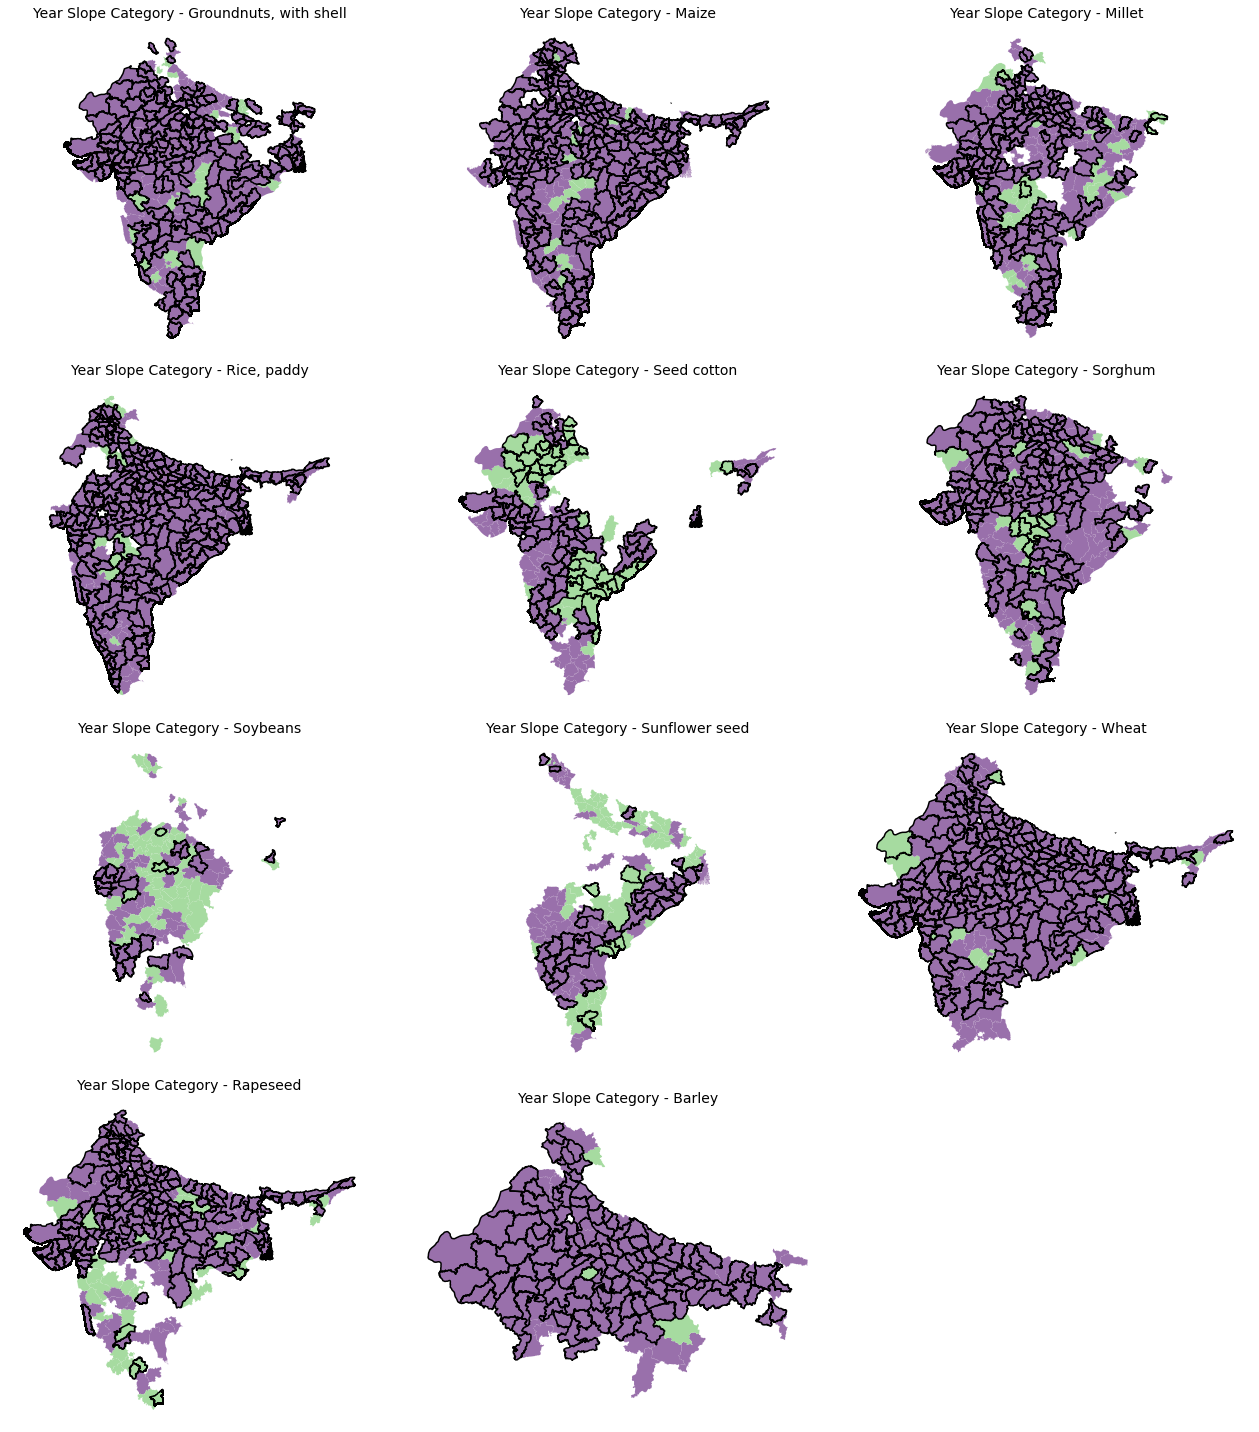

In [30]:
plot_facet_categorical(
    regs_plot,
    fill_var="slope_category",
    title="Year Slope Category",
    color_dict=slope_colors,
    color_var="year_pval",
    color_threshold=0.05)
